In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from numba import jit

import matplotlib.pyplot as plt
import seaborn as sns
import scienceplots

In [2]:
%matplotlib inline
plt.style.use(['nature', 'ieee', 'notebook'])

### Data Import

In [3]:
macro_proc = pd.read_excel('macro_excel.xlsx')
macro_proc.columns = macro_proc.columns.str.replace(' ', '')
macro_proc = (macro_proc - macro_proc.mean())/macro_proc.std()

### Gibbs sampler 

Same as in Assigment 2. Uses numba for precompilation and paralleling computations

#### Row processing 

Function *process_row* is the same as in Assignment 2

In [ ]:
row = pd.Series([1, 1, 1, 1, None, None, X.values, y.values, None, None], index=['a', 'b', 'A', 'B', 's', 'Ry', 'X', 'y', 'beta', 'epsilon'])
results = process_row(row)

### Bivariate regression and statistical significance 

Rajouter les résultats de l'OLS (p-value + valeur de l'estimateur) et c'est bon.

In [7]:
y = macro_proc.loc[:, 'Outcome']
X = macro_proc.drop('Outcome', axis=1)

In [21]:
X_biv = X.loc[:, "gdpsh465"].to_frame()
# X_biv['const'] = 1

In [24]:
row = pd.Series([1, 1, 1, 1, None, None, X_biv.values, y.values, None, None], index=['a', 'b', 'A', 'B', 's', 'Ry', 'X', 'y', 'beta', 'epsilon'])
results = process_row(row)

  0%|          | 0/2000 [00:00<?, ?it/s]

In [25]:
betas = pd.DataFrame(results[2])
qs = pd.DataFrame(results[0])

In [26]:
qs

,0
0,0.500000
1,0.498629
2,0.506385
3,0.503511
4,0.485304
...,...
1995,0.211307
1996,0.195608
1997,0.183129
1998,0.185886


Posterior Distributions of $q$ and $\beta$

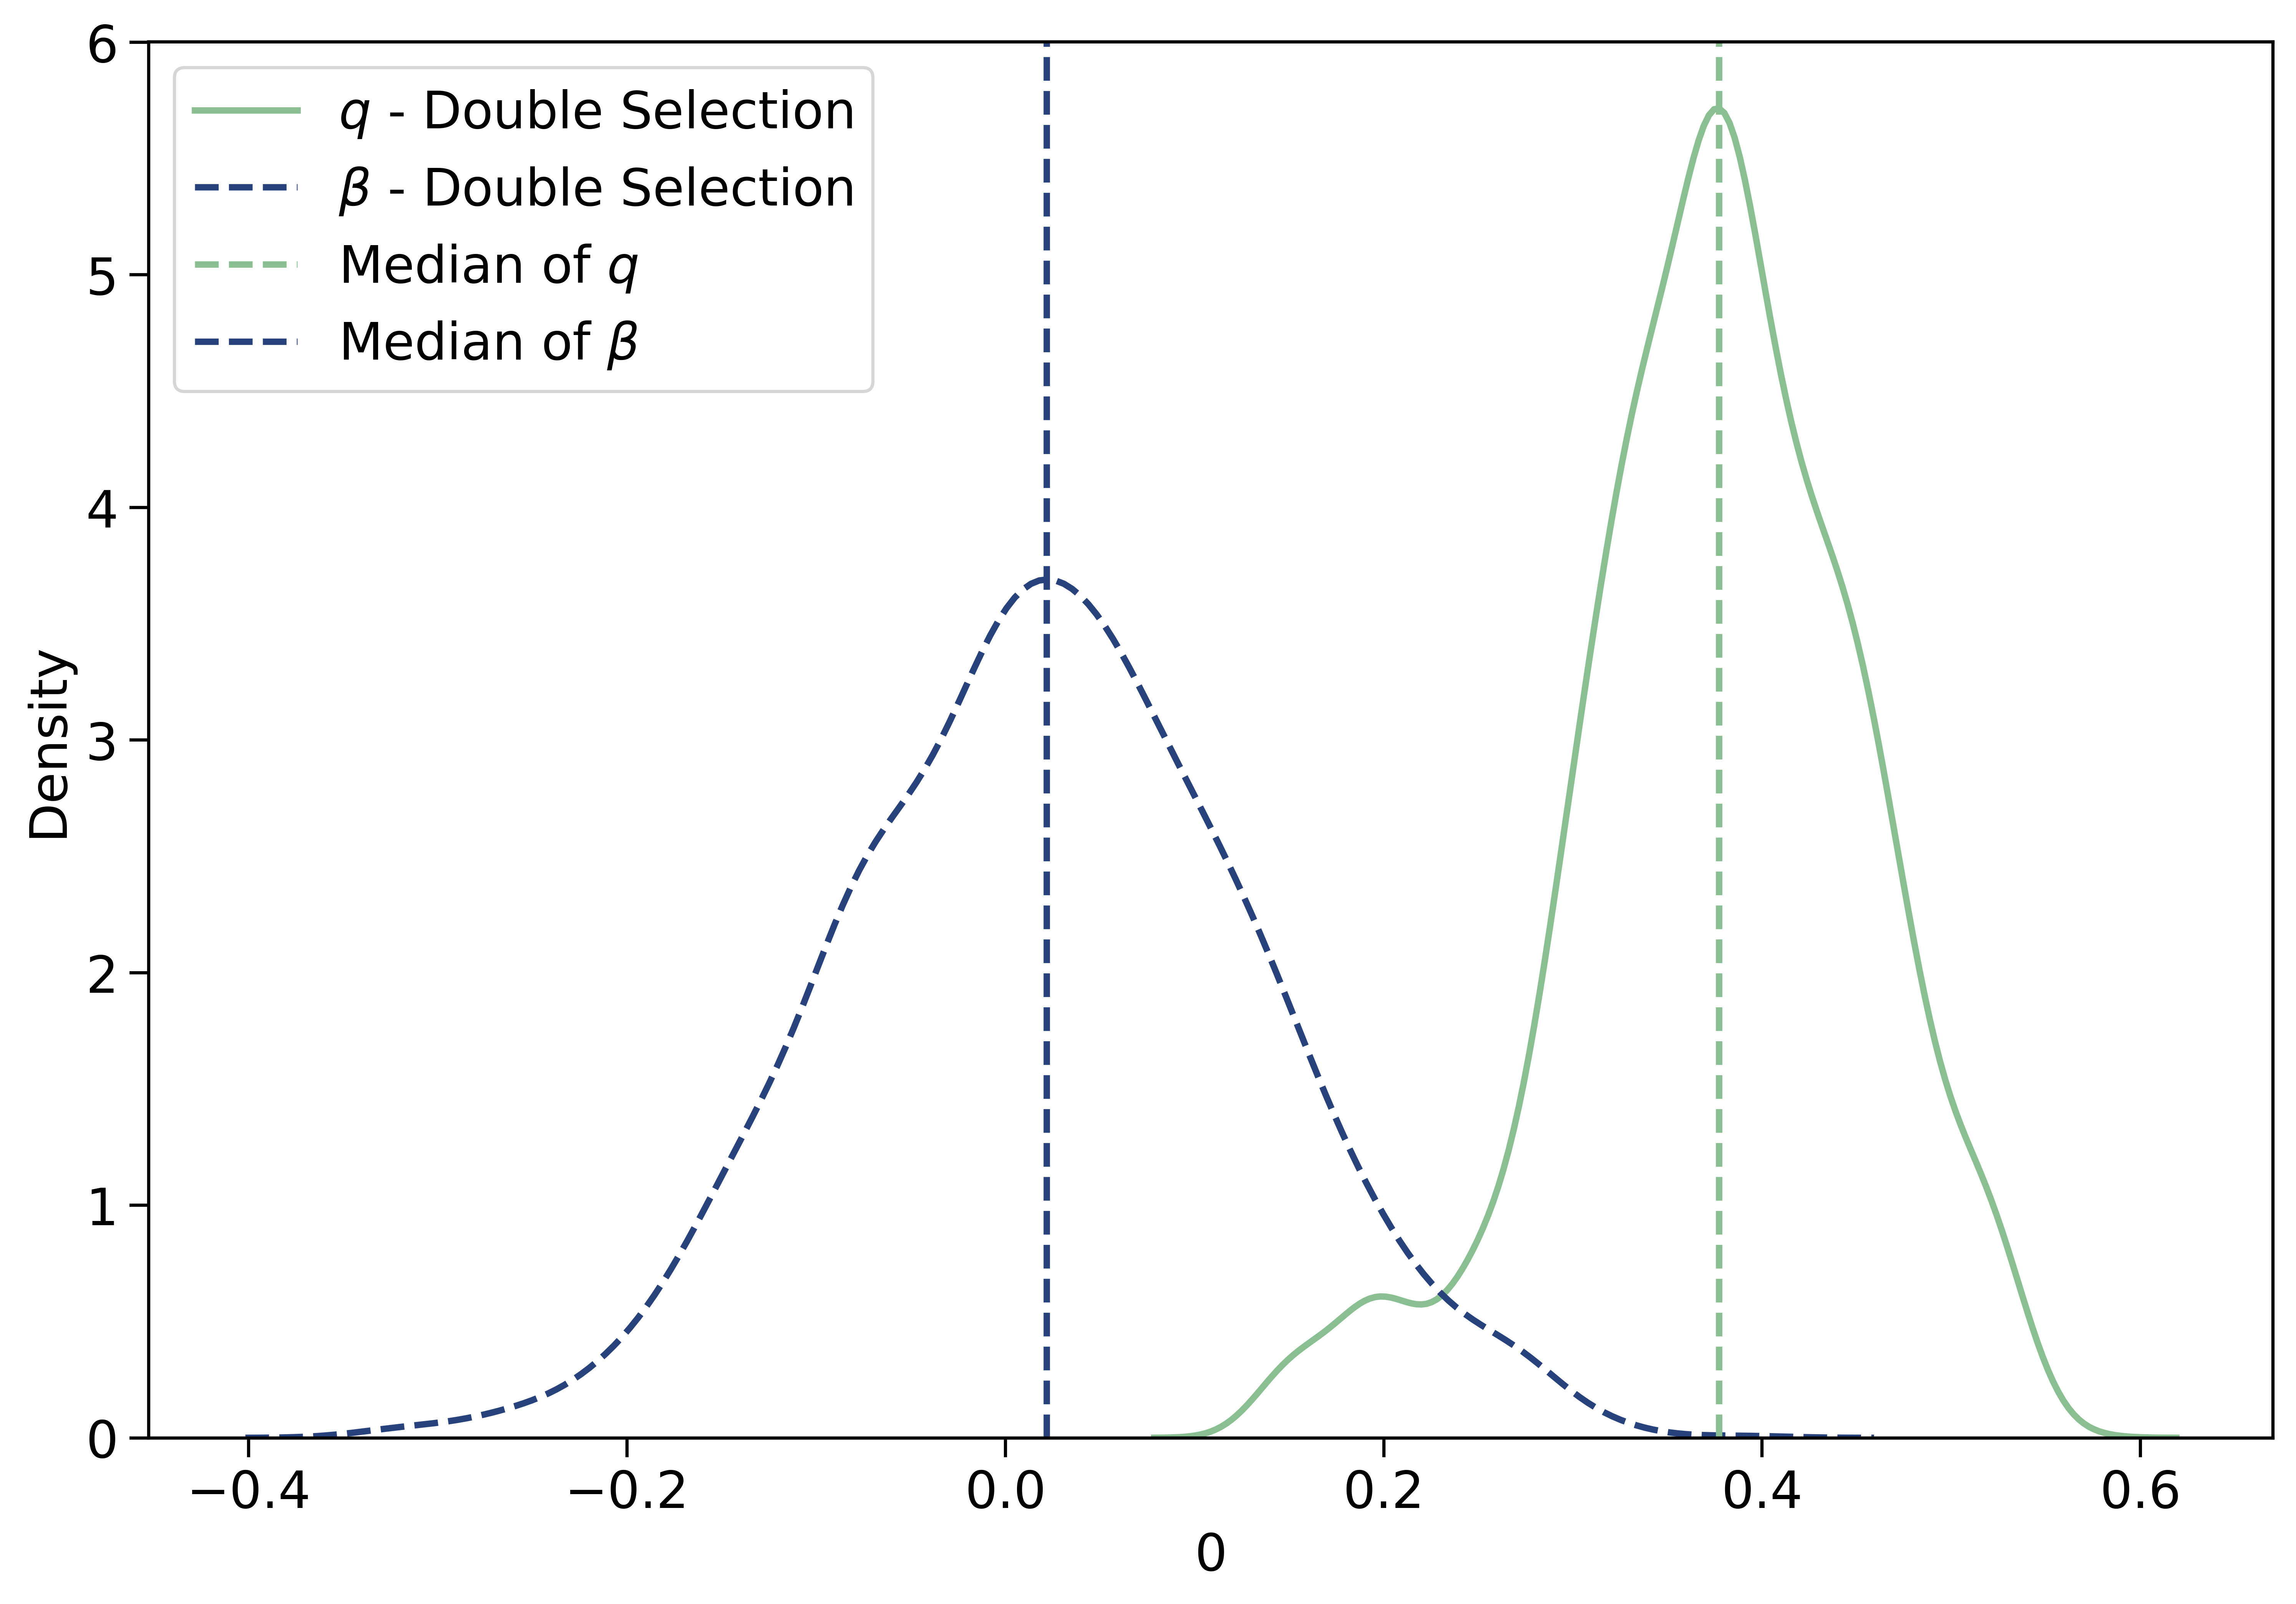

In [33]:
# Define color map
crest = sns.color_palette("crest", as_cmap=True)

# Plotting
fig, ax = plt.subplots(figsize=(10, 7))

# Plot for 'q' column
sns.kdeplot(data=qs, x=0, ax=ax, label=r'$q$ - Double Selection', color=crest(0.1), common_norm=False)
# Plot for 'beta' column
sns.kdeplot(data=betas, x=0, ax=ax, label=r'$\beta$ - Double Selection', color=crest(0.9), common_norm=False)

# Adding medians
q_median = qs[0].median()
beta_median = betas[0].median()
ax.axvline(q_median, color=crest(0.1), linestyle='--', label=f'Median of $q$')
ax.axvline(beta_median, color=crest(0.9), linestyle='--', label=f'Median of $\\beta$')

# Title and Legend
ax.legend()

# Adjust layout and display
plt.tight_layout()
plt.show()

<Axes: >

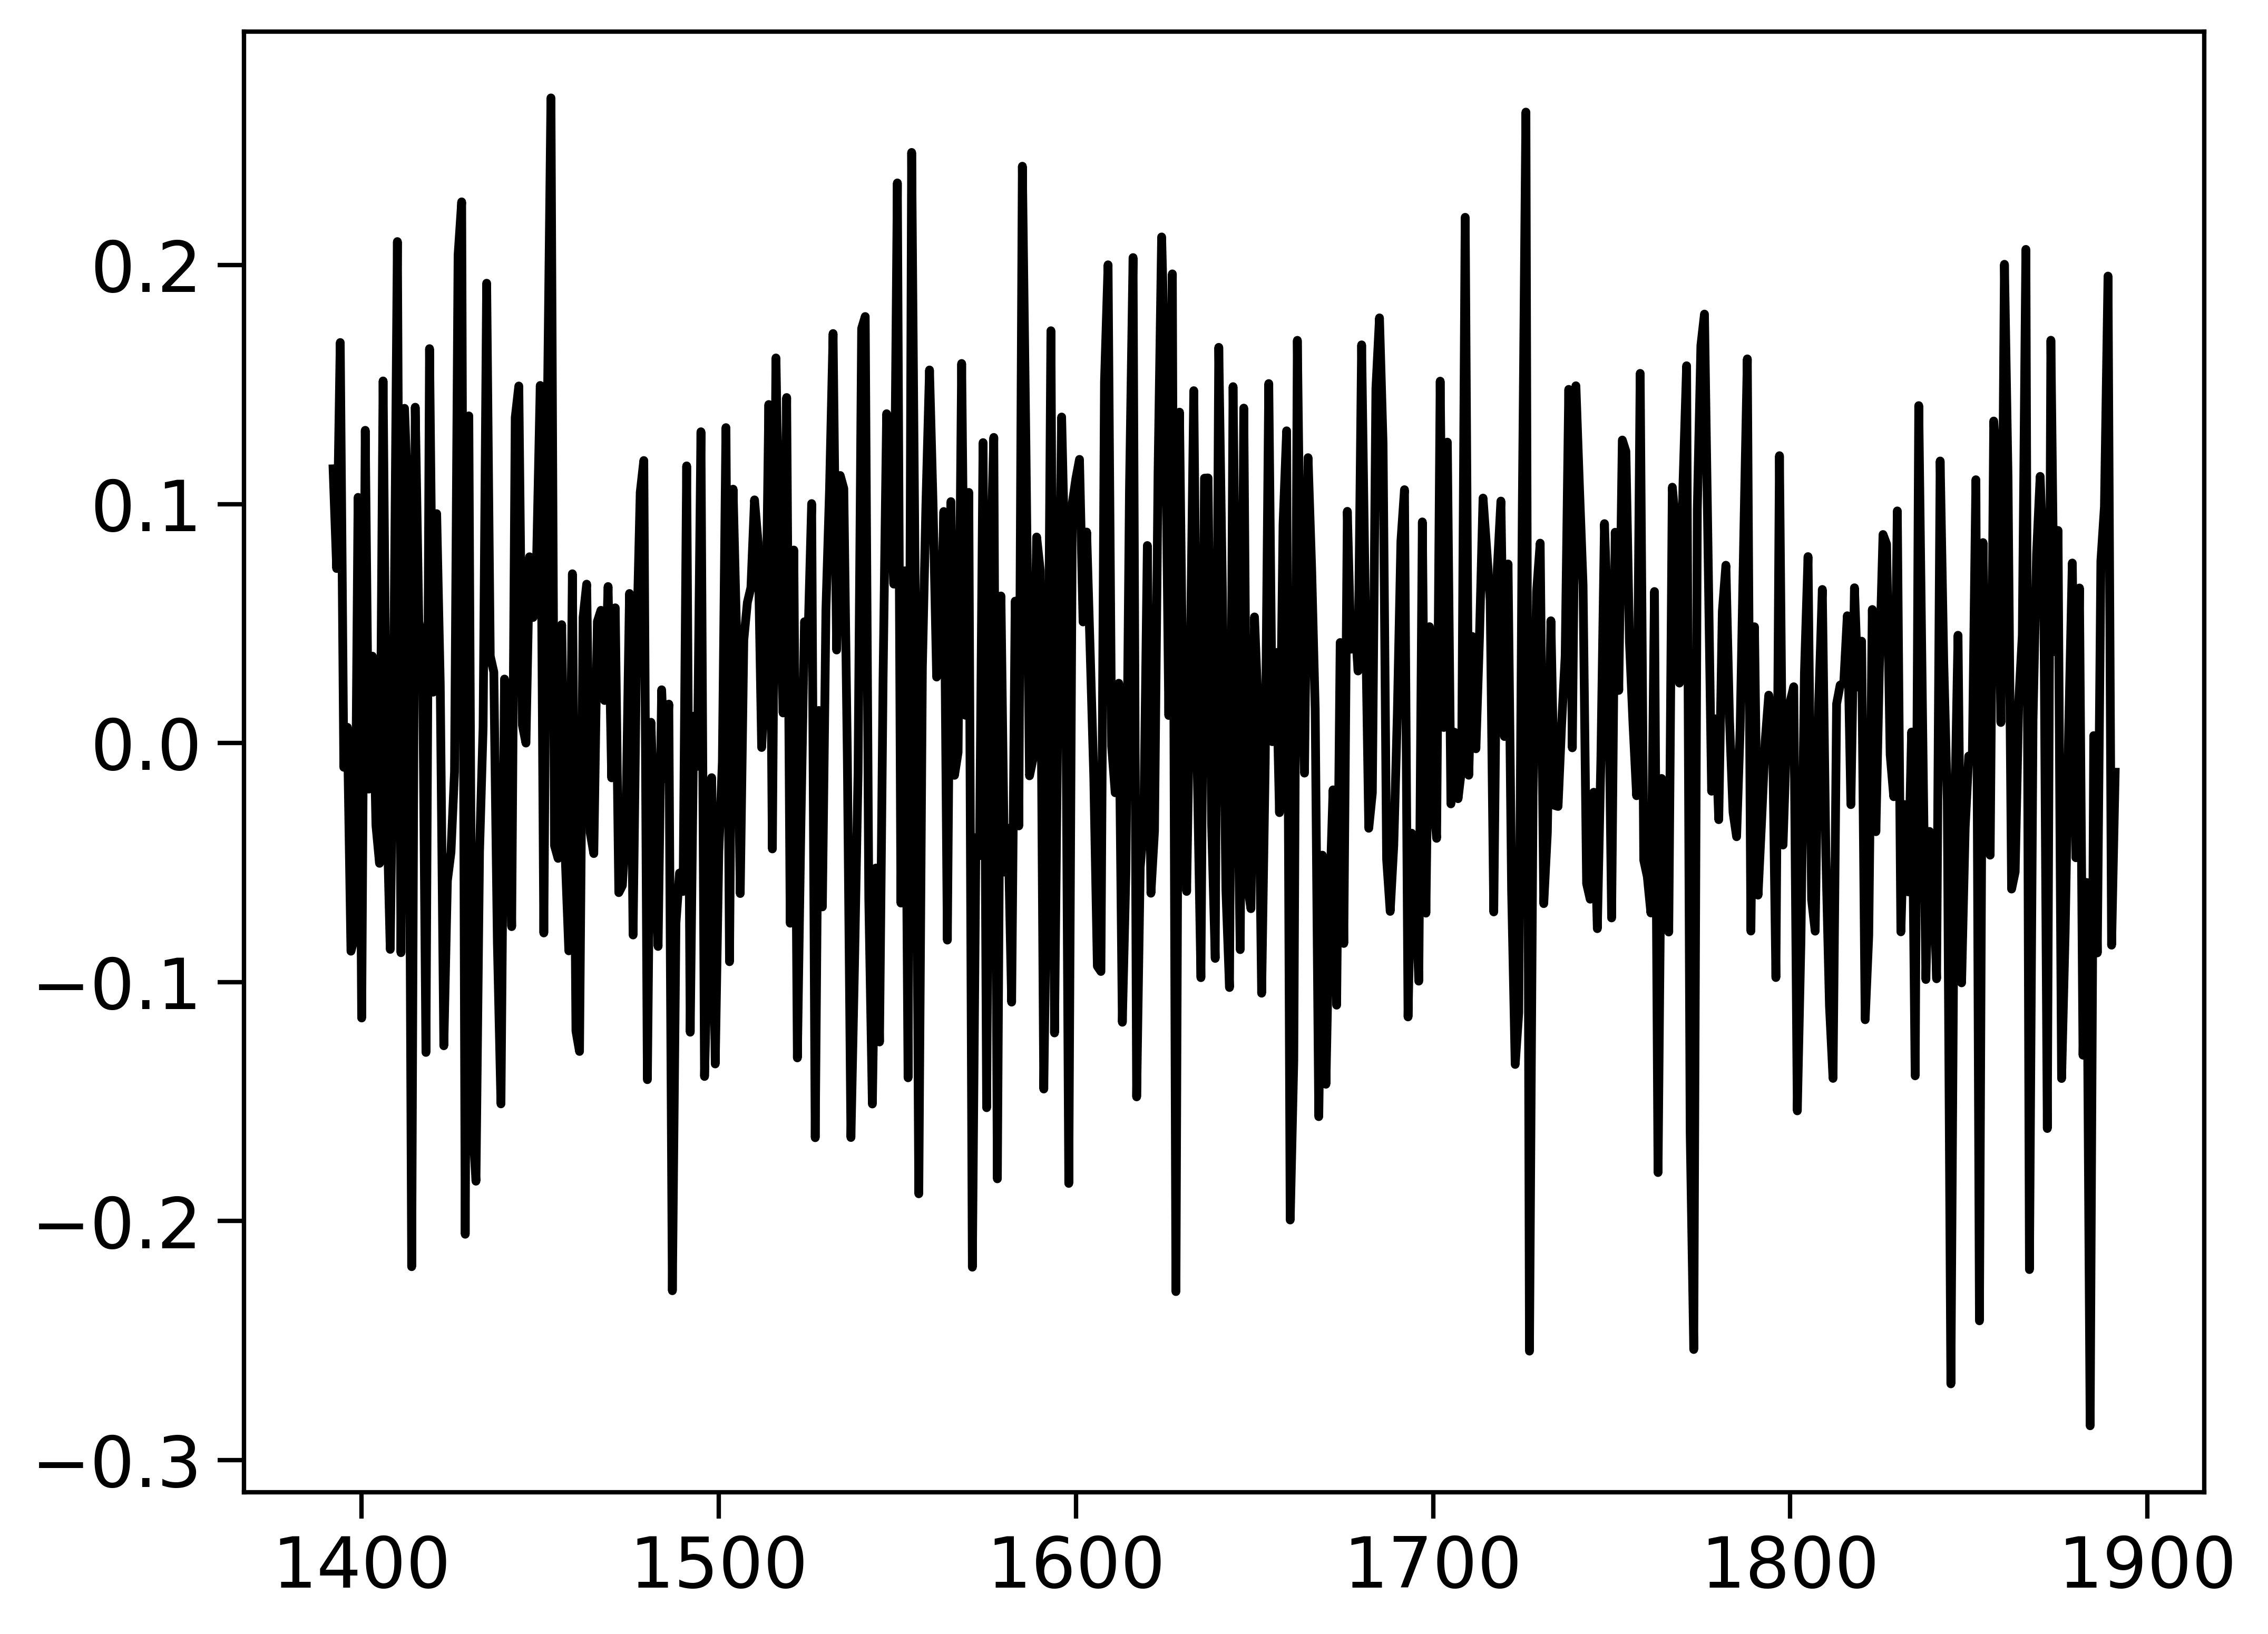

In [14]:
betas.iloc[-500:, 0].plot()

### Evolution of the sparsity of $\beta$ at each iteration of the Gibbs sampling

<Axes: >

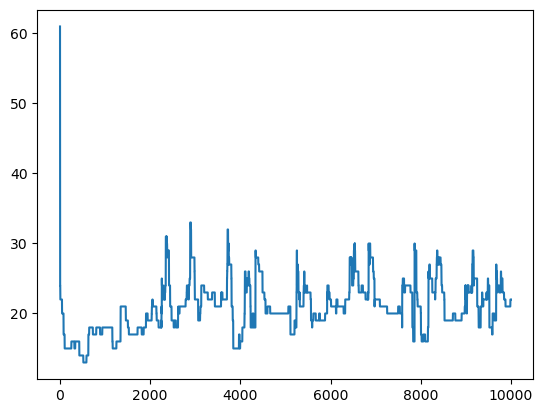

In [69]:
(pd.DataFrame(results[2]) == 0.).sum(axis=1).plot()

## Double selection with Gibbs Sampling 

In [34]:
def run_double_selection(X, y, IV):
    # First regression: Covariates on DV
    row_for_dv = pd.Series([1, 1, 1, 1, None, None, X.values, y.values, None, None],
                           index=['a', 'b', 'A', 'B', 's', 'Ry', 'X', 'y', 'beta', 'epsilon'])
    results_dv = process_row(row_for_dv)
    selected_covariates_dv = identify_selected_covariates(results_dv, X.columns)

    # Second regression: Covariates on IV
    row_for_iv = pd.Series([1, 1, 1, 1, None, None, X.values, IV.values, None, None],
                           index=['a', 'b', 'A', 'B', 's', 'Ry', 'X', 'y', 'beta', 'epsilon'])
    results_iv = process_row(row_for_iv)
    selected_covariates_iv = identify_selected_covariates(results_iv, X.columns)

    # Combine the selected covariates
    combined_covariates = selected_covariates_dv.intersection(selected_covariates_iv)

    # Final regression: Combined Covariates and IV on DV
    X_final = X[combined_covariates]
    X_final['IV'] = IV  # Add the IV to the predictors
    final_row = pd.Series([1, 1, 1, 1, None, None, X_final.values, y.values, None, None],
                          index=['a', 'b', 'A', 'B', 's', 'Ry', 'X', 'y', 'beta', 'epsilon'])
    
    final_results = process_row(final_row)
    final_covariates = X_final.columns
    
    # Prepare the output dictionary
    output = {
        "selected_covariates_dv": selected_covariates_dv,
        "selected_covariates_iv": selected_covariates_iv,
        "combined_covariates": combined_covariates,
        "intermediate_results_dv": results_dv,
        "intermediate_results_iv": results_iv,
        "final_results": final_results,
        "final_covariates": final_covariates
    }

    return output

def identify_selected_covariates(results, column_names):
    # Implement based on process_row output
    selected_covariates = {column_names[i] for i in range(len(column_names)) if results[2][-1][i] != 0}
    return selected_covariates


In [35]:
y = macro_proc.loc[:, 'Outcome']
X = macro_proc.drop('Outcome', axis=1)

In [36]:
iv = X.loc[:, 'gdpsh465']
y = y
X = X.drop('gdpsh465', axis=1)

In [37]:
final_results = run_double_selection(X, y, iv)

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

C:\Users\Hermes\AppData\Local\Temp\ipykernel_11340\3487297188.py:18: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  X_final = X[combined_covariates]
C:\Users\Hermes\AppData\Local\Temp\ipykernel_11340\3487297188.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_final['IV'] = IV  # Add the IV to the predictors


  0%|          | 0/2000 [00:00<?, ?it/s]

### Posteriors

#### With double-selection Regression

In [34]:
double_selection_posteriors = pd.DataFrame({"q": final_results['final_results'][0], "Ry":final_results['final_results'][1]})

array([[<Axes: title={'center': 'q'}>, <Axes: title={'center': 'Ry'}>]],
      dtype=object)

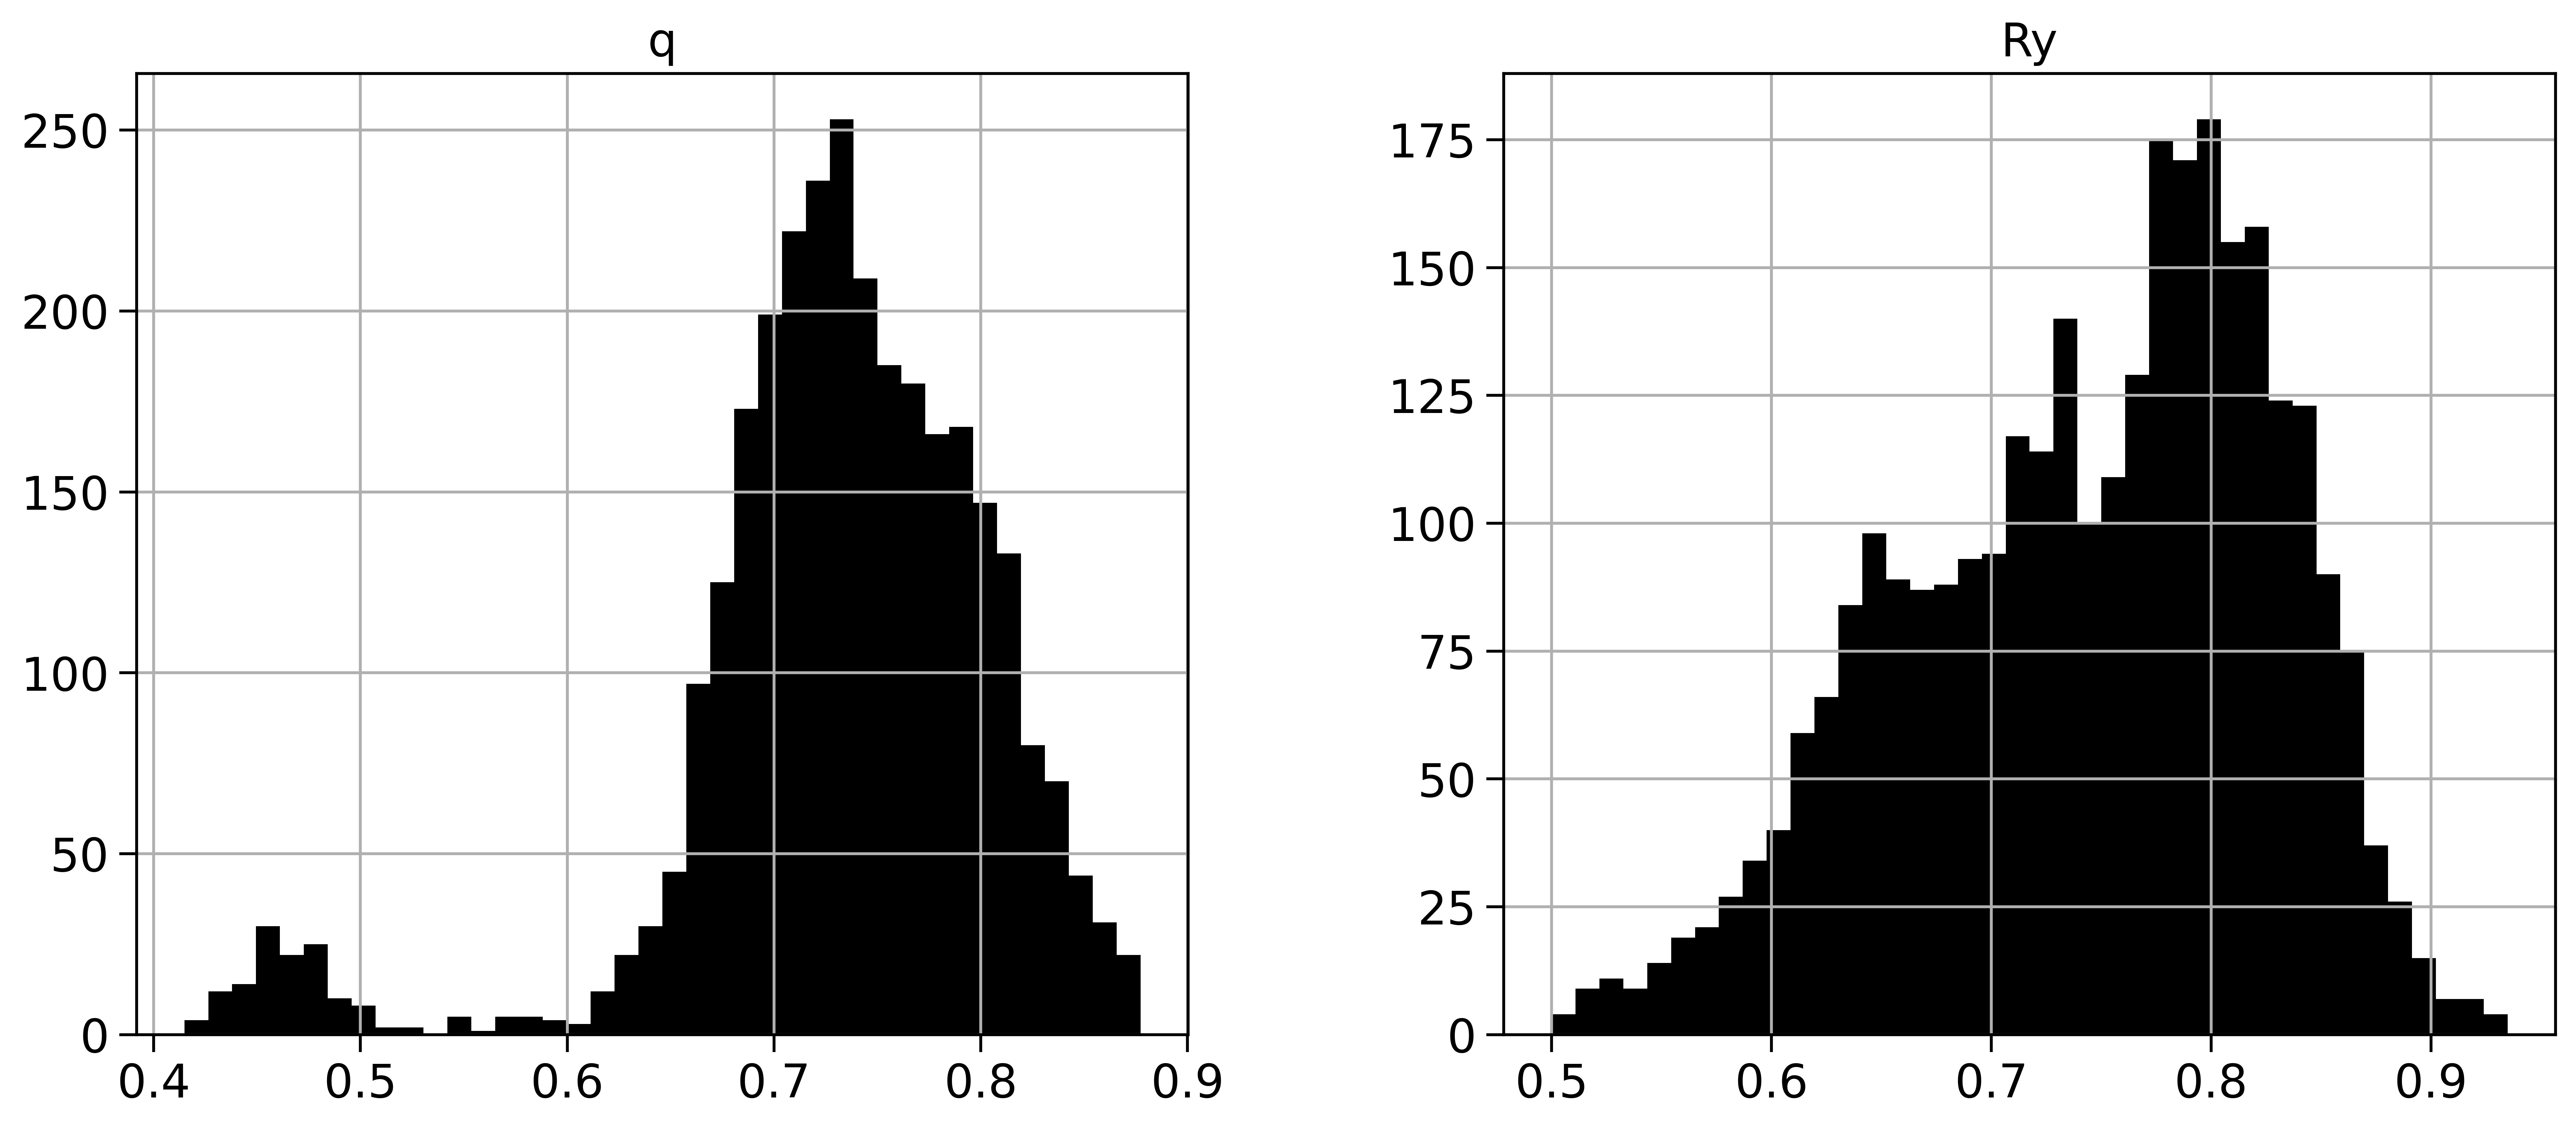

In [40]:
double_selection_posteriors.hist(figsize=(15, 6), bins=40)

#### Classic way (w\ Gibbs)

In [38]:
y = macro_proc.loc[:, 'Outcome']
X = macro_proc.drop('Outcome', axis=1)

In [ ]:
classic_row = final_row = pd.Series([1, 1, 1, 1, None, None, X.values, y.values, None, None],
                          index=['a', 'b', 'A', 'B', 's', 'Ry', 'X', 'y', 'beta', 'epsilon'])

classic_results = process_row(classic_row)

In [45]:
classic_posteriors = pd.DataFrame({"q": classic_results[0], "Ry": classic_results[1]})

array([[<Axes: title={'center': 'q'}>, <Axes: title={'center': 'Ry'}>]],
      dtype=object)

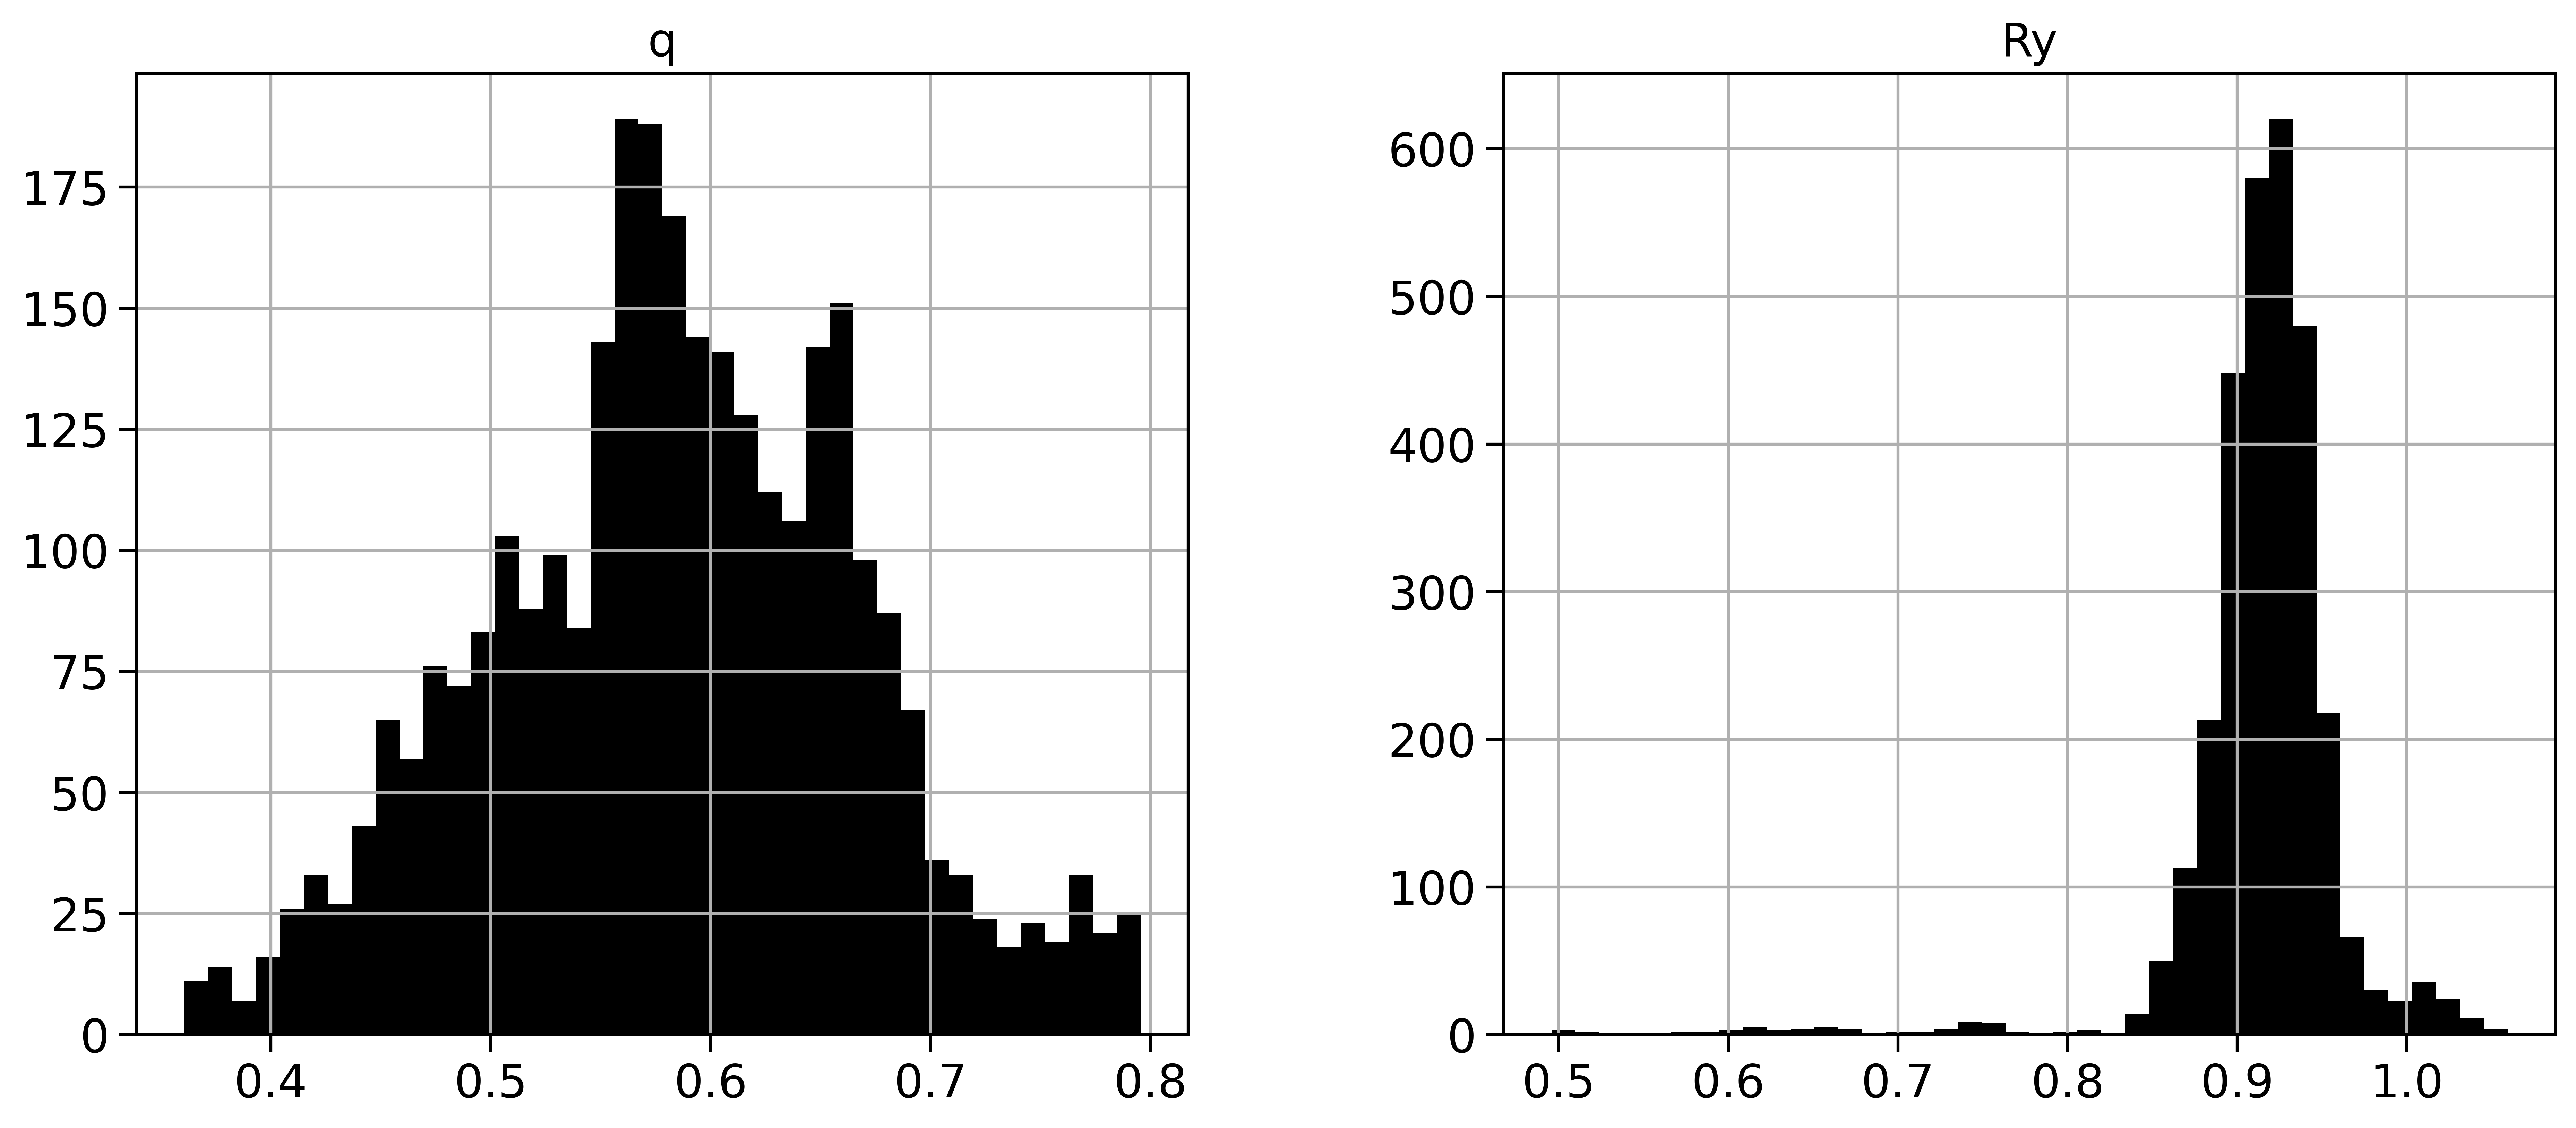

In [46]:
classic_posteriors.hist(figsize=(15, 6), bins=40)

#### KDE Comparison

In [159]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(20, 7))

# Define color map
crest = sns.color_palette("crest", as_cmap=True)

# Plot for 'q' column
sns.kdeplot(data=df1, x='q', ax=axs[0], label='Double Selection', color=crest(0.1), common_norm=False)
sns.kdeplot(data=df2, x='q', ax=axs[0], label='Classic', color=crest(0.9), common_norm=False)
axs[0].set_title(r'Posterior Distribution of $q$')
axs[0].axvline(np.median(df1['q']), color=crest(0.2), linestyle='--', label='Median - Double Selection')
axs[0].axvline(np.median(df2['q']), color=crest(0.9), linestyle='--', label='Median - Classic')
axs[0].legend()

# Plot for 'Ry' column
sns.kdeplot(data=df1, x='Ry', ax=axs[1], label='Double Selection', color=crest(0.1), common_norm=False)
sns.kdeplot(data=df2, x='Ry', ax=axs[1], label='Classic', color=crest(0.9), common_norm=False)
axs[1].set_title(r'Posterior Distribution of $R_y$')
axs[1].axvline(np.median(df1['Ry']), color=crest(0.2), linestyle='--', label='Median - Double Selection')
axs[1].axvline(np.median(df2['Ry']), color=crest(0.9), linestyle='--', label='Median - Classic')
axs[1].legend()

# Adjust layout and display
plt.tight_layout()
plt.show()


#### Cross-validation (3-fold)

In [ ]:
iv = X.loc[:, 'gdpsh465']
y = y
X = X.drop('gdpsh465', axis=1)

final_results = run_double_selection(X, y, iv)['final_results']
db_estimators_last = final_results[2][-1]

y = macro_proc.loc[:, 'Outcome']
X = macro_proc.drop('Outcome', axis=1)

classic_row = final_row = pd.Series([1, 1, 1, 1, None, None, X.values, y.values, None, None],
                          index=['a', 'b', 'A', 'B', 's', 'Ry', 'X', 'y', 'beta', 'epsilon'])

classic_results = process_row(classic_row)
cl_estimators = final_results[2][-1]

In [ ]:
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error

y = y
X_classic = X.copy()  
iv = X.loc[:, 'gdpsh465'] 
X_double_selection = X.drop('gdpsh465', axis=1) 

kf = KFold(n_splits=3, shuffle=True, random_state=42)

# Initialize lists to store MSE for each approach
mse_db = []
mse_cl = []

for train_index, test_index in kf.split(X):
    X_train_cl, X_test_cl = X_classic.iloc[train_index], X_classic.iloc[test_index]
    X_train_db, X_test_db = X_double_selection.iloc[train_index], X_double_selection.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    iv_train, iv_test = iv.iloc[train_index], iv.iloc[test_index]

    # Double Selection
    db_results = run_double_selection(X_train_db, y_train, iv_train)
    covar_double_selection = pd.Index(db_results['combined_covariates']).append(pd.Index(['gdpsh465']))
    double_selection_estimators = pd.Series(0, index=X.columns)
    double_selection_estimators[covar_double_selection] = db_results['final_results'][2][-1]
    y_pred_db = X_test_cl.dot(double_selection_estimators)
    mse_db.append(mean_squared_error(y_test, y_pred_db))

    # Classic Regression
    classic_row = pd.Series([1, 1, 1, 1, None, None, X_train_cl.values, y_train.values, None, None],
                            index=['a', 'b', 'A', 'B', 's', 'Ry', 'X', 'y', 'beta', 'epsilon'])
    cl_results = process_row(classic_row)
    classic_estimators = pd.Series(cl_results[2][-1], index=X.columns)
    y_pred_cl = X_test_cl.dot(classic_estimators)
    mse_cl.append(mean_squared_error(y_test, y_pred_cl))

# MSE Results
for i in range(3):
    print(f"Fold {i+1} - MSE Double Selection: {mse_db[i]}, MSE Classic: {mse_cl[i]}")


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

C:\Users\Hermes\AppData\Local\Temp\ipykernel_11340\3487297188.py:18: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  X_final = X[combined_covariates]
C:\Users\Hermes\AppData\Local\Temp\ipykernel_11340\3487297188.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_final['IV'] = IV  # Add the IV to the predictors


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

In [45]:
pd.Index(db_results['combined_covariates'])

Index(['humanm65', 'pinstab1', 'hm65', 'pf65', 'geetot1', 'tot1', 'geerec1',
       'highcf65', 'mort1', 'teasec65', 'pop65', 'hf65', 'invsh41', 'pop6565',
       'freetar', 'secc65', 'im1', 'teapri65', 'freeop', 'lifee065', 'pm65',
       'gde1', 'nof65', 'govwb1', 'worker65', 'xr65', 'sf65', 'bmp1l'],
      dtype='object')

### Estimators

In [162]:
final_estimators = pd.DataFrame({'value':final_results['final_results'][2][-1]}, index=list(final_results['final_covariates']))
final_estimators.loc[:, 'value'] = final_estimators.loc[:, 'value'].apply(abs)

In [169]:
print(final_estimators.sort_values('value', ascending=False).iloc[:8].T.to_latex())

\begin{tabular}{lrrrrrrrr}
\toprule
{} &        IV &     bmp1l &    syrm65 &     pm65 &      gde1 &    govwb1 &   pop1565 &    freeop \\
\midrule
value &  0.779961 &  0.488257 &  0.477292 &  0.45439 &  0.389918 &  0.333146 &  0.272273 &  0.205588 \\
\bottomrule
\end{tabular}



C:\Users\Hermes\AppData\Local\Temp\ipykernel_11712\1444881185.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(final_estimators.sort_values('value', ascending=False).iloc[:8].T.to_latex())


### Sparsity heatmap

In [112]:
final_results['final_results'][2][-1]

array([ 0.06600297,  0.01412377, -0.00877303, -0.15838107,  0.17081984,
       -0.17135321,  0.        ,  0.        ,  0.        ,  0.06581704,
        0.47729192,  0.        , -0.04032498,  0.45439044,  0.        ,
        0.        , -0.48825674,  0.        ,  0.        , -0.06520572,
        0.        ,  0.19545861, -0.27227283,  0.        ,  0.3899185 ,
        0.00851085,  0.20558761,  0.08161609, -0.33314591, -0.77996058])

In [134]:
covar_double_selection = final_results['final_covariates'].drop('IV').append(pd.Index(['gdpsh465']))

double_selection_estimators = pd.Series(0, index=X.columns)
double_selection_estimators[covar_double_selection] = final_results['final_results'][2][-1]

classic_estimators = pd.Series(classic_results[2][-1], index=X.columns)

In [155]:
estimators = pd.DataFrame({'Double-selection': double_selection_estimators, 'Classic':classic_estimators})

<Axes: >

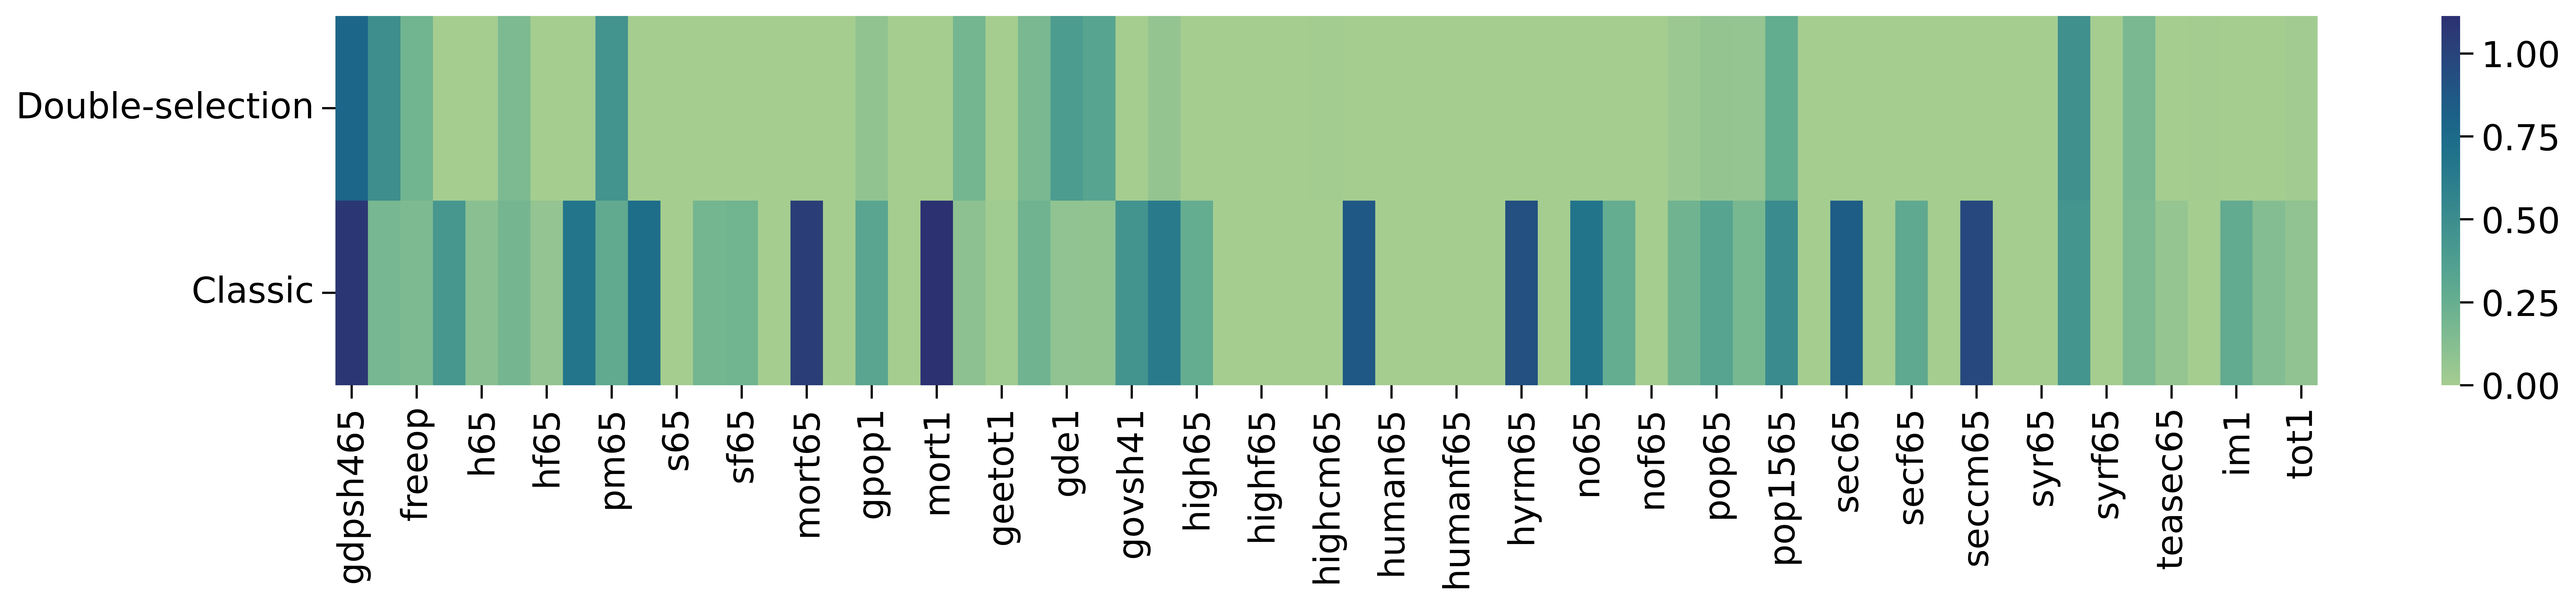

In [156]:
fig, ax =  plt.subplots()
fig.set_size_inches(20, 3)

sns.heatmap(estimators.T.apply(abs), ax=ax, cmap='crest')